# Entities

In [1]:
%matplotlib inline

import spacy
import random
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from utils import monitor
from spacy import displacy
from itertools import chain
from collections import Counter
from sklearn.datasets.lfw import Bunch

## Args

In [2]:
args = Bunch()

## Spacy 101

In [3]:
sample_text = '''But Google is starting from behind. The company made a late push \
into hardware, and Apple’s Siri, available on iPhones, and Amazon’s Alexa \
software, which runs on its Echo and Dot devices, have clear leads in \
consumer adoption.'''
sample_text

'But Google is starting from behind. The company made a late push into hardware, and Apple’s Siri, available on iPhones, and Amazon’s Alexa software, which runs on its Echo and Dot devices, have clear leads in consumer adoption.'

In [4]:
nlp = spacy.load('en')
doc = nlp(sample_text)

In [5]:
for token in doc[:10]:
    print(f'text={token.text} lemma={token.lemma_} pos={token.pos_}')

text=But lemma=but pos=CCONJ
text=Google lemma=google pos=PROPN
text=is lemma=be pos=VERB
text=starting lemma=start pos=VERB
text=from lemma=from pos=ADP
text=behind lemma=behind pos=ADV
text=. lemma=. pos=PUNCT
text=The lemma=the pos=DET
text=company lemma=company pos=NOUN
text=made lemma=make pos=VERB


In [6]:
print([chunk.text for chunk in doc.noun_chunks])

['Google', 'The company', 'a late push', 'hardware', 'Apple', 'Siri', 'iPhones', 'Amazon’s Alexa software', 'its Echo', 'Dot devices', 'clear leads', 'consumer adoption']


In [7]:
options = {'compact': True, 'bg': '#09a3d5',
           'color': 'white', 'font': 'Source Sans Pro'}
displacy.render(nlp(next(doc.sents).text), style='dep', options=options, jupyter=True)

In [8]:
doc.user_data['title'] = 'Apple vs Google'
displacy.render(doc, style='ent', jupyter=True)

## Collect entities

In [9]:
args.informative_poses = {'NOUN', 'PROPN'}
args.stop_words = {"doesn\\'t", 'it\\', 'user\\', 'return', ':return'}
args.log_step = 5000
args.data_path = 'data.hdf5'

### Fetch

In [10]:
def fetch_entity(desc):
    def norm(word):
        return word.strip().lower()
    
    def is_valid(word):
        return not nlp.vocab[word].is_stop and not 'dcnl' in word \
                    and not '_' in word and len(word) > 1 \
                    and not word in args.stop_words
    
    # Forming candidates
    doc = nlp(desc)
    ents = (ent.text for ent in doc.ents)
    lemmas = (token.lemma_ for token in doc \
              if token.pos_ in args.informative_poses and not token.lemma_.startswith('-'))
    noun_chunks = (chunk.text for chunk in doc.noun_chunks)
    candidates = (norm(candidate) for candidate in chain(ents, lemmas, noun_chunks))
    
    return set(candidate for candidate in candidates if is_valid(candidate))


def linearize(entity):
    return ', '.join(sorted(list(entity)))

In [11]:
linearize(fetch_entity(sample_text))

'a late push, adoption, alexa, amazon, amazon’s alexa software, apple, clear leads, company, consumer, consumer adoption, device, dot, dot devices, echo, google, hardware, iphones, its echo, lead, push, siri, software, the company'

### Collect

In [12]:
@monitor('[1.3.1] Collect entities')
def collect_entities(descs, *, exp):
    entities = []
    for i, desc in enumerate(tqdm(descs)):
        entities.append(fetch_entity(desc))
        if i % args.log_step == 0 or i == len(descs) - 1:
            exp.metric('step', i)
    return entities

In [13]:
df = pd.read_hdf(args.data_path)
len(df)

149511

In [14]:
%time entities = collect_entities(df.desc)
assert len(descs) == len(entities)
len(entities)

100%|██████████| 149511/149511 [2:16:19<00:00, 18.28it/s] 


CPU times: user 20h 30min 43s, sys: 1h 46s, total: 21h 31min 29s
Wall time: 2h 16min 21s


NameError: name 'descs' is not defined

In [ ]:
df['entity'] = [linearize(entity) for entity in entities]
df.head()

## Analysis

In [0]:
@hyperdash('[1.3.2] Join entities')
def join_entities(entities, *, exp):
    cum_cnt = Counter()
    for i, entity in enumerate(tqdm(entities)):
        cum_cnt += Counter(entity)
        if i % LOG_STEP == 0 or i == len(descs) - 1:
            exp.metric('step', i)
    return cum_cnt

In [15]:
%time ecnts = join_entities(entities)
len(ecnts)

  0%|          | 0/171148 [00:00<?, ?it/s]

| step:   0.000000 |


  3%|▎         | 4996/171148 [00:02<01:08, 2412.03it/s]

| step: 5000.000000 |


  6%|▌         | 9993/171148 [00:07<02:02, 1313.69it/s]

| step: 10000.000000 |


  9%|▉         | 14978/171148 [00:17<03:05, 843.50it/s]

| step: 15000.000000 |


 12%|█▏        | 19976/171148 [00:35<04:31, 557.08it/s]

| step: 20000.000000 |


 15%|█▍        | 24987/171148 [01:00<05:52, 415.08it/s]

| step: 25000.000000 |


 18%|█▊        | 29997/171148 [01:30<07:03, 333.04it/s]

| step: 30000.000000 |


 20%|██        | 34991/171148 [02:03<08:01, 282.55it/s]

| step: 35000.000000 |


 23%|██▎       | 39996/171148 [02:42<08:53, 245.89it/s]

| step: 40000.000000 |


 26%|██▋       | 44994/171148 [03:25<09:35, 219.30it/s]

| step: 45000.000000 |


 29%|██▉       | 49991/171148 [04:12<10:11, 198.18it/s]

| step: 50000.000000 |


 32%|███▏      | 54991/171148 [05:03<10:40, 181.41it/s]

| step: 55000.000000 |


 35%|███▌      | 59995/171148 [05:57<11:02, 167.68it/s]

| step: 60000.000000 |


 38%|███▊      | 64995/171148 [06:56<11:20, 156.06it/s]

| step: 65000.000000 |


 41%|████      | 69996/171148 [07:58<11:31, 146.21it/s]

| step: 70000.000000 |


 44%|████▍     | 74993/171148 [09:04<11:38, 137.73it/s]

| step: 75000.000000 |


 47%|████▋     | 79999/171148 [10:14<11:39, 130.28it/s]

| step: 80000.000000 |


 50%|████▉     | 84999/171148 [11:27<11:37, 123.58it/s]

| step: 85000.000000 |


 53%|█████▎    | 89998/171148 [12:45<11:30, 117.61it/s]

| step: 90000.000000 |


 56%|█████▌    | 95000/171148 [14:05<11:18, 112.30it/s]

| step: 95000.000000 |


 58%|█████▊    | 99996/171148 [15:29<11:01, 107.60it/s]

| step: 100000.000000 |


 61%|██████▏   | 104998/171148 [16:57<10:41, 103.17it/s]

| step: 105000.000000 |


 64%|██████▍   | 109996/171148 [18:28<10:16, 99.19it/s]

| step: 110000.000000 |


 67%|██████▋   | 115000/171148 [20:03<09:47, 95.56it/s]

| step: 115000.000000 |


 70%|███████   | 120000/171148 [21:40<09:14, 92.25it/s]

| step: 120000.000000 |


 73%|███████▎  | 124998/171148 [23:21<08:37, 89.17it/s]

| step: 125000.000000 |


 76%|███████▌  | 129999/171148 [25:07<07:57, 86.24it/s]

| step: 130000.000000 |


 79%|███████▉  | 134999/171148 [26:56<07:12, 83.52it/s]

| step: 135000.000000 |


 82%|████████▏ | 139999/171148 [28:48<06:24, 81.01it/s]

| step: 140000.000000 |


 85%|████████▍ | 144999/171148 [30:43<05:32, 78.66it/s]

| step: 145000.000000 |


 88%|████████▊ | 149999/171148 [32:41<04:36, 76.46it/s]

| step: 150000.000000 |


 91%|█████████ | 154998/171148 [34:42<03:36, 74.43it/s]

| step: 155000.000000 |


 93%|█████████▎| 159997/171148 [36:46<02:33, 72.50it/s]

| step: 160000.000000 |


 96%|█████████▋| 165000/171148 [38:55<01:27, 70.65it/s]

| step: 165000.000000 |


 99%|█████████▉| 169997/171148 [41:08<00:16, 68.86it/s]

| step: 170000.000000 |


100%|█████████▉| 171145/171148 [41:39<00:00, 68.46it/s]

| step: 171147.000000 |


100%|██████████| 171148/171148 [41:40<00:00, 68.46it/s]


This run of [1.3.2] Join entities ran for 0:41:40 and logs are available locally at: /content/.hyperdash/logs/1-3-2-join-entities/1-3-2-join-entities_2018-03-19t04-26-33-522404.log
CPU times: user 41min 28s, sys: 24 s, total: 41min 52s
Wall time: 41min 41s


229910

In [16]:
%store ecnts

Stored 'ecnts' (Counter)


In [17]:
ecnts.most_common(50)

[('return', 18611),
 ('test', 17629),
 ('list', 10556),
 ('object', 10079),
 ('value', 8947),
 ('file', 8515),
 ('method', 8392),
 ('function', 7848),
 ('param', 7701),
 ('string', 7617),
 ('instance', 7296),
 ('user', 6737),
 ('datum', 5610),
 ('parameter', 5391),
 ('request', 5375),
 ('returns', 5009),
 ('type', 4780),
 ('argument', 4480),
 ('args', 4393),
 ('a list', 4271),
 ('number', 4176),
 ('default', 4125),
 ('error', 3943),
 ('message', 3702),
 ('class', 3554),
 ('path', 3528),
 ('api', 3483),
 ('field', 3368),
 ('response', 3207),
 ('dictionary', 3142),
 ('result', 3125),
 ('dict', 3104),
 ('rtype', 3086),
 ('information', 3084),
 ('key', 2991),
 ('attribute', 2980),
 ('version', 2922),
 ('exception', 2794),
 ('command', 2784),
 ('state', 2745),
 ('tests', 2728),
 ('server', 2677),
 ('model', 2529),
 ('connection', 2497),
 ('module', 2476),
 ('line', 2452),
 ('resource', 2448),
 ('page', 2438),
 ('time', 2430),
 ('this method', 2415)]

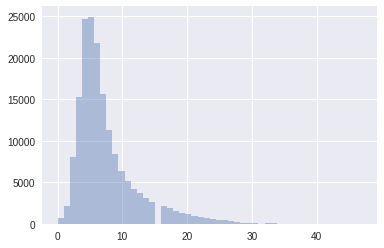

In [18]:
sns.distplot([len(entity) for entity in entities], hist=True, kde=False);

In [19]:
entities = [sorted(sorted(entity, key=lambda x: ecnts[x])[:5]) 
            for entity in tqdm(entities)]
assert len(descs) == len(entities)
len(entities)

100%|██████████| 171148/171148 [00:01<00:00, 115321.10it/s]


171148

In [20]:
edescs = [', '.join(entity) + ' | ' + desc for desc, entity in zip(descs, entities)]
assert len(descs) == len(edescs)
len(edescs)

171148

In [21]:
random.sample(edescs, 10)

['node kinds, param kinds, param limit, random content nodes, randomly selected content dictionaries | Convenience function for returning random content nodes for use in testing DCNL :param kinds: A list of node kinds to select from. DCNL :param limit: The maximum number of items to return. DCNL :return: A list of randomly selected content dictionaries.',
 'char, chars, entity refs, ref, tag name | Add child with tag name and content. DCNL Convert replaces entity refs to chars.',
 'permission, roleinstance, the permission, twilio.rest.chat.v1.service.role.roleinstance, unicode | Update the RoleInstance DCNL :param unicode permission: The permission DCNL :returns: Updated RoleInstance DCNL :rtype: twilio.rest.chat.v1.service.role.RoleInstance',
 'callback, parameter, sensor, sensor test parameters, test | Callback for sensor test parameters',
 'chromosome, segment, the current chromosome segment | Draw the current chromosome segment.',
 'a ratemeasurer, rate, ratemeasurer, sample, the r

In [22]:
%store edescs

Stored 'edescs' (list)


## End

In [55]:
args

{'informative_poses': {'NOUN', 'PROPN'},
 'log_step': 5000,
 'stop_words': {':return', "doesn\\'t", 'it\\', 'return', 'user\\'}}